# Step 1 - Install the required dependencies and make sure the python version is 3.10 and above

In [1]:
!pip install zenoml

  Using cached zenoml-0.6.4-py3-none-any.whl.metadata (7.1 kB)
  Using cached fastapi-0.100.1-py3-none-any.whl.metadata (23 kB)
  Using cached inquirer-3.4.0-py3-none-any.whl.metadata (6.8 kB)
  Using cached pathos-0.3.3-py3-none-any.whl.metadata (11 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached uvicorn-0.23.2-py3-none-any.whl.metadata (6.2 kB)
  Using cached zeno_sliceline-0.0.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached starlette-0.27.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached blessed-1.20.0-py2.py3-none-any.whl.metadata (13 kB)
  Using cached editor-1.6.6-py3-none-any.whl.metadata (2.3 kB)
  Using cached readchar-4.2.1-py3-none-any.whl.metadata (7.5 kB)
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
  Using cached python_dateutil-2.9.0.post0-py2.py3-none-any.whl.metadata (8.4 kB)
  Using cached pytz-2025.1-py2.py3-none-any.whl.metadata (22

In [2]:
!pip install datasets
!pip install transformers
!pip install tqdm
!pip install torch

  Using cached datasets-3.4.1-py3-none-any.whl.metadata (19 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.5.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py39-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached huggingface_hub-0.29.3-py3-none-any.whl.metadata (13 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached async_timeout-5.0.1-py3-none-any.whl.metadata (5.1 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
  Using cached frozenlist-1.5.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (13 kB)
  Using cached yarl-1.18.3-cp39-cp39-macosx_11_0_arm64.whl.metadata (69 kB)
Using cached 

In [3]:
!python --version

Python 3.9.21


# Step 2 - Load a dataset from Hugging Face

In [4]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("cardiffnlp/tweet_eval", "sentiment")
df = pd.DataFrame(ds['test']).head(500)
df.head(5)

/opt/miniconda3/envs/albumy_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,text,label
0,@user @user what do these '1/2 naked pics' hav...,1
1,OH: “I had a blue penis while I was this” [pla...,1
2,"@user @user That's coming, but I think the vic...",1
3,I think I may be finally in with the in crowd ...,2
4,"@user Wow,first Hugo Chavez and now Fidel Cast...",0


In [5]:
def label_map(x):
    if x == 0:
        return 'negative'
    elif x == 1:
        return 'neutral'
    elif x == 2:
        return 'positive'
    return x
df['label'] = df['label'].map(label_map)

# Step 3 - Run model inference

Warning: This step is going to download two models of ~500MB each. 

**If you don't want to download the models, you can jump to step 4 and use the provided data in the repo instead.**

### Run inference with roberta

In [6]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


In [7]:
import tqdm

results = []
texts = df['text'].to_list()

## Depending on your machine, this should take around 1 minute
for text in tqdm.tqdm(texts):
    results.append(pipe(text))

100%|██████████| 500/500 [00:09<00:00, 54.61it/s]


In [8]:
df['roberta'] = [r[0]['label'] for r in results]
df['roberta_score'] = [r[0]['score'] for r in results]

### Run inference with gpt2

In [9]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="LYTinn/finetuning-sentiment-model-tweet-gpt2")

Device set to use mps:0


In [10]:
import tqdm

results = []
texts = df['text'].to_list()

## Depending on your machine, this should take around 1 minute
for text in tqdm.tqdm(texts):
    results.append(pipe(text))

100%|██████████| 500/500 [00:07<00:00, 62.69it/s]


In [11]:
df['gpt2'] = [r[0]['label'] for r in results]
df['gpt2_score'] = [r[0]['score'] for r in results]

## map labels back
def label_map(x):
    if x == 'LABEL_0':
        return 'negative'
    elif x == 'LABEL_1':
        return 'neutral'
    elif x == 'LABEL_2':
        return 'positive'
    return x
df['gpt2'] = df['gpt2'].map(label_map)

# Step 4 - Pre-processing data and add additional columns

In [9]:
## If you skip the model inference, uncomment the code below and load the provided data

# df = pd.read_csv('tweets.csv')

In [12]:
df["input_length"] = df["text"].str.len()

# Step 5 - Start Zeno for interactive slicing

In this step, you need to create 5 slices in the Zeno interface and derive meaningful insights.

As a starting point, try to create the two slices we provide:

1. Tweets with hashtags
2. Tweets with strong positive words (e.g., love) -- you can determine the exact words

Creating slices in Zeno is straightforward: Just click on the '+' button for 'create a new slice', and you can define the slice using existing column attributes, with simple value macthing or even regular expression.

![image.png](images/image.png)

There are more fun features in Zeno, including interactive metadata & model comparison -- feel free to check the teaser video in [README](https://github.com/zeno-ml/zeno) of the Zeno repository.

In [ ]:
## Execute the code here to start a local Zeno server

from zeno import zeno

from zeno.api import model, distill, metric
from zeno.api import ModelReturn, MetricReturn, DistillReturn, ZenoOptions

@model
def load_model(model_name):
    
    def pred(df, ops: ZenoOptions):
        out = df[model_name]
        return ModelReturn(model_output=out)

    return pred

@distill
def label_match(df, ops: ZenoOptions):
    results = (df[ops.label_column] == df[ops.output_column]).to_list()
    return DistillReturn(distill_output=results)

@metric
def accuracy(df, ops: ZenoOptions):
    avg = df[ops.distill_columns["label_match"]].mean()
    return MetricReturn(metric=avg)

zeno({
    "metadata": df, # Pandas DataFrame with a row for each instance
    "view": "text-classification", # The type of view for this data/task
    "data_column": "text", 
    "label_column": "label",
    "functions": [load_model, label_match, accuracy],
    "models": ["roberta", "gpt2"],
    "port": 8231
})


Running predistill functions
Zeno running on http://localhost:8231


Running inference


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Inference on gpt2: 100%|██████████| 500/500 [00:00<00:00, 1359.77it/s]


Running postdistill functions


postprocessing label_match on gpt2: 100%|██████████| 500/500 [00:00<00:00, 1806.93it/s]


Done processing


/opt/miniconda3/envs/albumy_env/lib/python3.9/site-packages/zeno/processing/histogram_processing.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filt_df.groupby([pd.cut(filt_df[str(col)], bucs)])  # type: ignore
/opt/miniconda3/envs/albumy_env/lib/python3.9/site-packages/zeno/processing/histogram_processing.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filt_df.groupby([pd.cut(filt_df[str(col)], bucs)])  # type: ignore
/opt/miniconda3/envs/albumy_env/lib/python3.9/site-packages/zeno/processing/histogram_processing.py:95: FutureWarning: The default of observed=False is deprecated and will be changed

After running the code above, you should be able to access Zeno in http://localhost:8231


After successfully creating the two slices, come up with three *additional* slices you want to check and **create** the slices in the Zeno interface.

There are two directions to identify useful slices:
- Top-down: Think about what kinds of things the model can struggle with, and come up with some slices.
- Bottom-up: Look at model (mis-)predictions, come up with hypotheses, and translate them into data slices.

3. [YOUR CHOICE]
4. [YOUR CHOICE]
5. [YOUR CHOICE]

In [ ]:
## Write down descriptions of additional slices you created

custom_slice_descriptions = [
    "Tweets with string negative words",
    "Tweets containing questions",
    "Tweets with mentions",
]

# Step 6 - Write down three addition data slices you want to create but do not have the metadata for slicing

In the previous step, you might have already come up with some slices you wanted to create but found it hard to do with existing metadata. Write down three of such slices in this step.

Example: 
- I want to create a slice on tweets using slangs
- I want to create a slice on non-English tweets (if any)

In [ ]:
## Write down three additional data slices here:

additional_slice_descriptions = [
    "Tweets with sarcasm or irony",
    "Tweets with emoji usage",
    "Tweets with repeated letters for emphasis",
]

# Step 7 - Generate more test cases with Large Language Models

Select one slice from the three you wrote down and generate **10 test cases** using LLMs, which can include average case, boundary case, or difficult case.

Your input can be in the following format:

> Examples:
> - OH: “I had a blue penis while I was this” [playing with Google Earth VR]
> - @user @user That’s coming, but I think the victims are going to be Medicaid recipients.
> - I think I may be finally in with the in crowd #mannequinchallenge  #grads2014 @user
> 
> Generate more tweets using slangs.

The first part of **Examples** conditions the LLM on the style, length, and content of examples. The second part of **Instructions** instructs what kind of examples you want LLM to generate.

Use our provided GPTs to start the task: [llm-based-test-case-generator](https://chatgpt.com/g/g-982cylVn2-llm-based-test-case-generator). If you do not have access to GPTs, use the plain ChatGPT or other LLM providers you have access to instead.

In [ ]:
## Write down all generated test cases here

slice_description = "Tweets with repeated letters for emphasis"

## Write down all generated test cases here

generated_test_cases = [
    "Omgggg this pizza is soooo goooood!!! 🍕🔥",
    "@user Nooooo wayyy, I can’t believe this is happening!!! 😱",
    "Stooooppppp lying, we all know what really happened. 👀",
    "Yessssssss finally got the tickets!!! Can’t wait!!! 🎉🎶",
    "Awwwwwwww look at this cute little pupperrrr!!! 🐶💕",
    "@user @user Whyyyy do I always miss the best moments?! 😭",
    "Bruhhhhhh this game is rigged, no way that shot missed. 😤🏀",
    "Hahhahahahaha I can’t stop laughing at this!!! 😂😂😂",
    "Ewwwwww nooo, why would you even say that?! 🤢😩",
    "@user Okkkkkk fiiine, you win this time. 😏",
]

### Screenshots
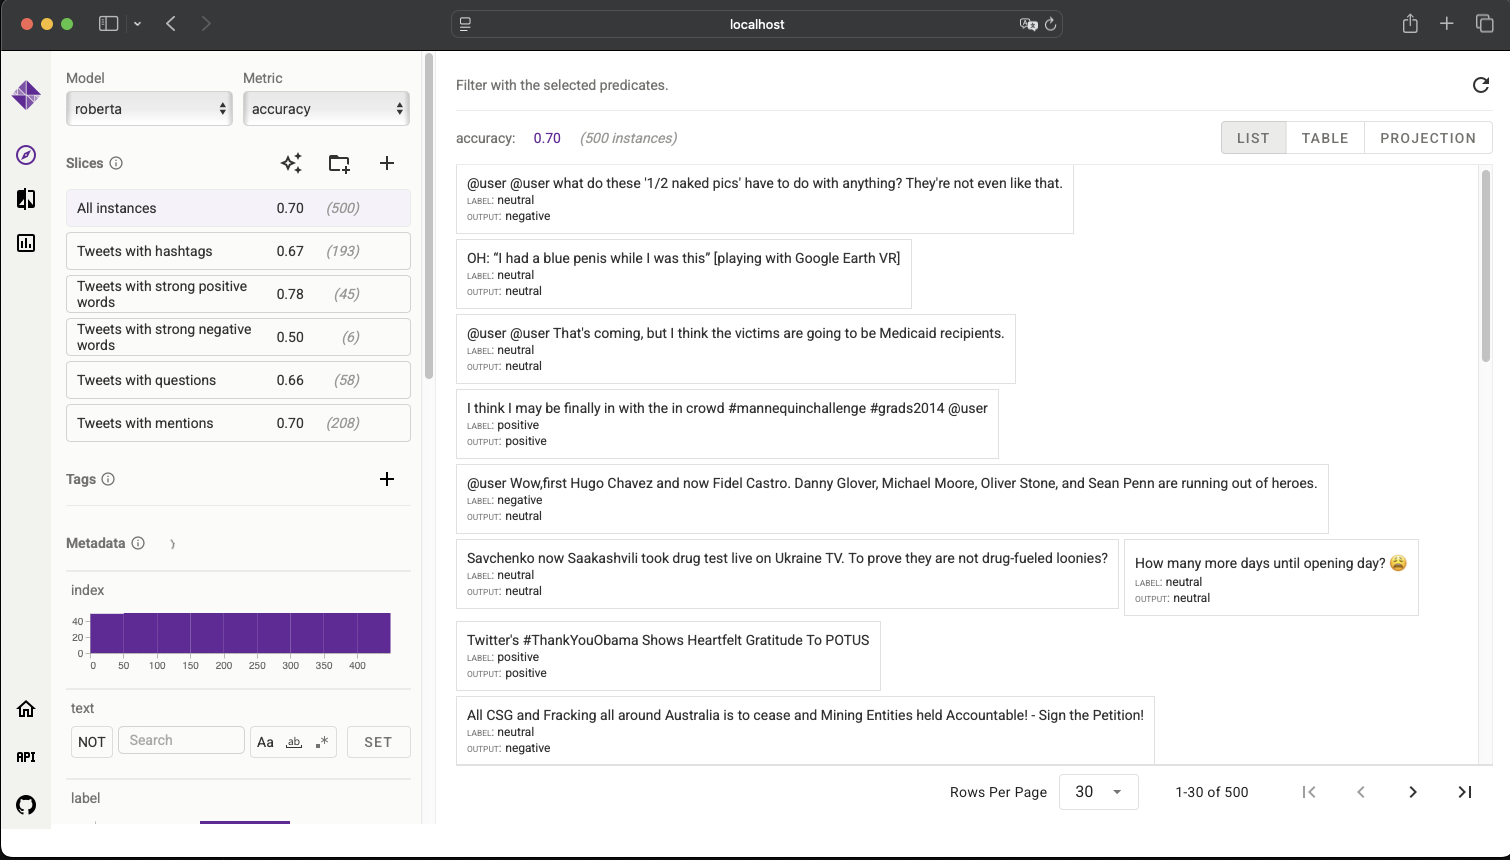